# License 
***
Copyright (C) 2017-2022 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# Kaggle House Prices with GLRM Matrix Factorization Example

1. General imports and inits

In [ ]:
import matplotlib as plt
%matplotlib inline
import numpy as np
import pandas as pd

# to upload local files
import io
from google.colab import files  

SEED = 12345 # for better reproducibility

2. Install Java for h2o 

In [ ]:
# install Java for h2o backend
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
openjdk version "11.0.14.1" 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


3. Install h2o

In [ ]:
# install h2o
!pip install h2o 

     |████████████████████████████████| 177.0 MB 18 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.1-py2.py3-none-any.whl size=177068062 sha256=8b9fdd464f78c9d53a994e6ffeb99b7dd64d6255db84b45149cc6744e7c9d048
  Stored in directory: /root/.cache/pip/wheels/a6/d9/ab/5442447c7e2ccf07f66aa8b79f3877ce5382f0b95e6c0c797b
Successfully built h2o


4. Import and start h2o

In [ ]:
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp288elggo
  JVM stdout: /tmp/tmp288elggo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp288elggo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,23 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_unknownUser_cqzajf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Helper Functions

5. Determine data types

In [ ]:
def get_type_lists(frame, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

6. Impute with GLRM

In [ ]:
def glrm_num_impute(role, frame):

    """ Helper function for imputing numeric variables using GLRM.
    
    :param role: Role of frame to be imputed.
    :param frame: H2OFrame to be imputed.
    :return: H2OFrame of imputed numeric features.
    
    """
    
    # count missing values in training data numeric columns
    print(role + ' missing:\n', [cnt for cnt in frame.nacnt() if cnt != 0.0])

    # initialize GLRM
    matrix_complete_glrm = H2OGeneralizedLowRankEstimator(
        k=10,                      # create 10 features, REQUIRES STUDENT INPUT 
        transform='STANDARDIZE', # <- seems very important
        gamma_x=0.001,           # regularization on values in X
        gamma_y=0.05,            # regularization on values in Y
        seed=SEED,                   # REQUIRES STUDENT INPUT
        impute_original=True)

    # train GLRM
    matrix_complete_glrm.train(training_frame=frame, x=original_nums)

    # plot iteration history to ensure convergence
    matrix_complete_glrm.score_history().plot(x='iterations', y='objective', title='GLRM Score History')

    # impute numeric inputs by multiplying the calculated xi and yj for the missing values in train
    num_impute = matrix_complete_glrm.predict(frame)

    # count missing values in imputed set
    print('imputed ' + role + ' missing:\n', [cnt for cnt in num_impute.nacnt() if cnt != 0.0])
    
    return num_impute

7. Embed with GLRM 

In [ ]:
def glrm_cat_embed(frame):
    
    """ Helper function for embedding caetgorical variables using GLRM.
    
    :param frame: H2OFrame to be embedded.
    :return: H2OFrame of embedded categorical features.
    
    """
    
    # initialize GLRM
    cat_embed_glrm = H2OGeneralizedLowRankEstimator(
        k=50, # REQUIRES STUDENT INPUT
        transform='STANDARDIZE',
        loss='Quadratic',
        regularization_x='Quadratic',
        regularization_y='L1',
        gamma_x=0.25,
        gamma_y=0.5,
        seed=SEED) # REQUIRES STUDENT INPUT

    # train GLRM
    cat_embed_glrm.train(training_frame=frame, x=cats)

    # plot iteration history to ensure convergence
    cat_embed_glrm.score_history().plot(x='iterations', y='objective', title='GLRM Score History')

    # extracted embedded features
    cat_embed = h2o.get_frame(cat_embed_glrm._model_json['output']['representation_name'])
    
    return cat_embed

8. Import train data

In [ ]:
# special google collab command to upload a file from computer
uploaded = files.upload() # REQUIRES STUDENT INPUT

Saving train.csv to train.csv


In [ ]:
# 9 
uploaded.keys() # what is stored in that Python object?

dict_keys(['train.csv'])

10. Load train and test data

In [ ]:
train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8'))) # name in quotes here must match name in 6 above
train = h2o.H2OFrame(train) # convert to h2o

print(train.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(1460, 81)


11. Determine input feature measurement levels

In [ ]:
original_nums, cats = get_type_lists(train)

Numeric = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Categorical = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',

12. Split into to train and validation (before doing data prep!!!)

In [ ]:
train, valid = train.split_frame([0.7], seed=SEED) # REQUIRES STUDENT INPUT
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


13. Impute numeric missing using GLRM matrix completion in training data

training missing:
 [179.0, 7.0, 48.0]
glrm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
glrm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
imputed training missing:
 []


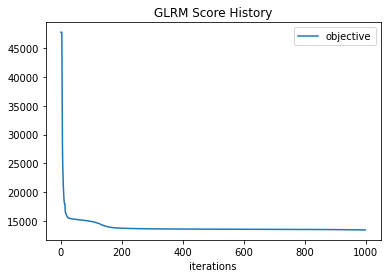

In [ ]:
train_num_impute = glrm_num_impute('training', train)

14. Inspect imputed training data 

In [ ]:
train_num_impute.head()

reconstr_MSSubClass,reconstr_LotFrontage,reconstr_LotArea,reconstr_OverallQual,reconstr_OverallCond,reconstr_YearBuilt,reconstr_YearRemodAdd,reconstr_MasVnrArea,reconstr_BsmtFinSF1,reconstr_BsmtFinSF2,reconstr_BsmtUnfSF,reconstr_TotalBsmtSF,reconstr_1stFlrSF,reconstr_2ndFlrSF,reconstr_LowQualFinSF,reconstr_GrLivArea,reconstr_BsmtFullBath,reconstr_BsmtHalfBath,reconstr_FullBath,reconstr_HalfBath,reconstr_BedroomAbvGr,reconstr_KitchenAbvGr,reconstr_TotRmsAbvGrd,reconstr_Fireplaces,reconstr_GarageYrBlt,reconstr_GarageCars,reconstr_GarageArea,reconstr_WoodDeckSF,reconstr_OpenPorchSF,reconstr_EnclosedPorch,reconstr_3SsnPorch,reconstr_ScreenPorch,reconstr_PoolArea,reconstr_MiscVal,reconstr_MoSold,reconstr_YrSold
100.2,61.7625,7147.29,6.90494,5.21513,1997.99,1999.94,160.366,592.201,50.7091,250.873,893.783,956.012,786.295,8.75929,1751.07,0.746311,-0.0680921,1.8799,0.910455,2.95499,1.03907,7.07958,0.571503,2002.47,2.17164,568.2,142.236,55.7654,4.6024,-8.50383,-1.51778,2.78743,-91.771,4.17287,2008.85
30.3395,84.2024,20840.5,6.2055,7.50561,1962.7,1995.05,159.564,787.1,-96.6578,460.515,1150.96,1280.01,166.112,-5.12071,1441,0.304783,0.571971,1.39223,0.065198,2.70352,0.846635,5.83769,0.762571,1970.21,1.64264,456.616,239.688,-2.11734,23.7554,32.4608,-39.3048,10.9351,240.716,6.56241,2007.28
86.5286,66.8285,8155.25,6.94773,5.12827,1998.19,1996.73,167.288,556.582,35.6741,357.341,949.597,1026.92,707.632,-14.5587,1719.99,0.598535,0.0143079,1.82202,0.902207,2.86485,1.00815,6.85263,0.765706,1999.2,2.23749,580.325,107.047,79.2117,-6.60266,1.51646,27.1416,-1.5781,-144.765,7.46699,2007.58
87.0459,87.8415,14237.4,7.79448,5.17553,2004.28,2003.55,277.651,755.675,8.44946,458.189,1222.31,1335.38,1009.88,-21.3071,2323.95,0.631121,0.0790071,2.27324,1.07073,3.51058,1.09552,8.57617,1.15683,2004.52,2.66402,699.236,154.533,103.79,-18.4366,8.86939,32.8711,9.86674,-147.739,8.61329,2007.25
62.4402,69.1372,15465.8,5.57221,6.75408,1993.59,2003.53,45.303,838.822,-34.0855,-26.4899,778.246,983.444,69.2207,-64.5229,988.142,0.789657,0.31284,1.48418,0.195025,2.40114,1.04578,4.95571,0.28269,1992.22,1.66145,424.711,194.693,43.1951,-97.0233,44.6804,-5.84479,-29.7145,62.2913,11.2054,2006.88
51.2755,80.5674,15601.9,7.3058,5.24004,2004.97,2002.84,219.088,1154.33,50.3392,469.733,1674.4,1695.65,44.1354,0.6216,1740.4,1.05541,0.106922,1.92464,0.0998495,2.50341,1.05061,6.58691,0.839242,2004.75,2.4289,690.606,176.581,70.1765,-8.05102,14.9888,4.9414,21.6682,175.16,7.42561,2007.35
86.3493,59.0296,5983.7,5.61897,4.54278,1926.32,1949.25,253.131,269.61,-120.59,962.918,1111.94,1365.97,519.692,27.6471,1913.31,-0.00292833,0.00977723,1.60128,0.194963,3.49228,1.47332,8.17005,0.725016,1943.04,1.65557,434.729,-55.4176,-22.0123,131.772,-15.3817,16.1845,2.89029,70.3145,4.65155,2008.11
53.2672,72.0088,10252.7,4.92693,5.65759,1956.61,1971.56,31.0389,695.802,94.2575,188.23,978.29,1102.93,-118.994,12.1427,996.082,0.866434,-0.0210858,1.07462,-0.0217117,2.31001,1.09395,5.08008,0.32294,1964.77,1.2996,369.1,75.3856,1.52187,35.4737,-2.88736,4.41918,-2.03496,-37.7536,4.28384,2008.88
95.4637,86.2891,15845.2,8.12251,5.12335,2003.67,2005.68,333.628,968.135,-22.0443,490.862,1436.95,1541.9,1016.49,2.59758,2560.99,0.74667,0.122007,2.47547,0.894685,3.65363,1.17361,9.17617,1.16274,2006.41,2.76791,745.247,190.073,92.771,3.84771,8.50622,6.66397,28.9384,17.3805,7.59357,2007.25
35.1202,59.016,10256.2,4.77545,6.01856,1954.62,1967.93,4.79522,724.641,129.304,67.1439,921.089,1052.67,-177.202,-32.9215,842.549,0.879529,0.0102914,0.798874,0.166289,2.09575,0.994961,4.48624,0.659865,1957.05,1.21744,334.535,20.376,40.1882,-4.1723,6.97086,77.4188,-14.5185,193.441,8.2839,2007.81


15. Impute numeric missing using GLRM matrix completion in validation data

validation missing:
 [80.0, 1.0, 33.0]
glrm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
glrm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
imputed validation missing:
 []


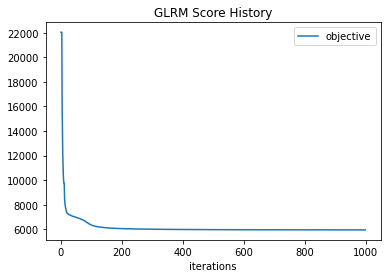

In [ ]:
valid_num_impute = glrm_num_impute('validation', valid)

16. Embed categorical vars in training data with GLRM

glrm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%


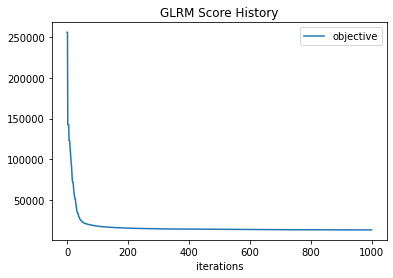

In [ ]:
train_cat_embed = glrm_cat_embed(train) # runs for a long time

17. Embed categorical vars in validation data with GLRM

glrm Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [Utilities]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████████████| (done) 100%


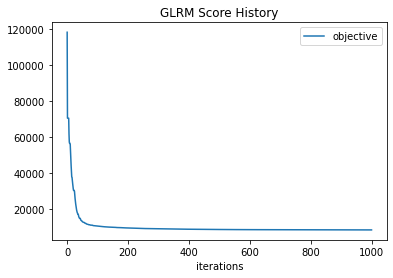

In [ ]:
valid_cat_embed = glrm_cat_embed(valid) # runs for a long time

18. Merge imputed and embedded frames

In [ ]:
imputed_embedded_train = train[['Id', 'SalePrice']].cbind(train_num_impute).cbind(train_cat_embed)
imputed_embedded_valid = valid[['Id', 'SalePrice']].cbind(valid_num_impute).cbind(valid_cat_embed)

19. Redefine numeric inputs and explore

In [ ]:
imputed_embedded_nums, cats = get_type_lists(imputed_embedded_train)

print('Imputed and encoded numeric training data:')
imputed_embedded_train.describe() 
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
imputed_embedded_valid.describe() 


Numeric = ['reconstr_MSSubClass', 'reconstr_LotFrontage', 'reconstr_LotArea', 'reconstr_OverallQual', 'reconstr_OverallCond', 'reconstr_YearBuilt', 'reconstr_YearRemodAdd', 'reconstr_MasVnrArea', 'reconstr_BsmtFinSF1', 'reconstr_BsmtFinSF2', 'reconstr_BsmtUnfSF', 'reconstr_TotalBsmtSF', 'reconstr_1stFlrSF', 'reconstr_2ndFlrSF', 'reconstr_LowQualFinSF', 'reconstr_GrLivArea', 'reconstr_BsmtFullBath', 'reconstr_BsmtHalfBath', 'reconstr_FullBath', 'reconstr_HalfBath', 'reconstr_BedroomAbvGr', 'reconstr_KitchenAbvGr', 'reconstr_TotRmsAbvGrd', 'reconstr_Fireplaces', 'reconstr_GarageYrBlt', 'reconstr_GarageCars', 'reconstr_GarageArea', 'reconstr_WoodDeckSF', 'reconstr_OpenPorchSF', 'reconstr_EnclosedPorch', 'reconstr_3SsnPorch', 'reconstr_ScreenPorch', 'reconstr_PoolArea', 'reconstr_MiscVal', 'reconstr_MoSold', 'reconstr_YrSold', 'Arch1', 'Arch2', 'Arch3', 'Arch4', 'Arch5', 'Arch6', 'Arch7', 'Arch8', 'Arch9', 'Arch10', 'Arch11', 'Arch12', 'Arch13', 'Arch14', 'Arch15', 'Arch16', 'Arch17', 'Arc

,Id,SalePrice,reconstr_MSSubClass,reconstr_LotFrontage,reconstr_LotArea,reconstr_OverallQual,reconstr_OverallCond,reconstr_YearBuilt,reconstr_YearRemodAdd,reconstr_MasVnrArea,reconstr_BsmtFinSF1,reconstr_BsmtFinSF2,reconstr_BsmtUnfSF,reconstr_TotalBsmtSF,reconstr_1stFlrSF,reconstr_2ndFlrSF,reconstr_LowQualFinSF,reconstr_GrLivArea,reconstr_BsmtFullBath,reconstr_BsmtHalfBath,reconstr_FullBath,reconstr_HalfBath,reconstr_BedroomAbvGr,reconstr_KitchenAbvGr,reconstr_TotRmsAbvGrd,reconstr_Fireplaces,reconstr_GarageYrBlt,reconstr_GarageCars,reconstr_GarageArea,reconstr_WoodDeckSF,reconstr_OpenPorchSF,reconstr_EnclosedPorch,reconstr_3SsnPorch,reconstr_ScreenPorch,reconstr_PoolArea,reconstr_MiscVal,reconstr_MoSold,reconstr_YrSold,Arch1,Arch2,Arch3,Arch4,Arch5,Arch6,Arch7,Arch8,Arch9,Arch10,Arch11,Arch12,Arch13,Arch14,Arch15,Arch16,Arch17,Arch18,Arch19,Arch20,Arch21,Arch22,Arch23,Arch24,Arch25,Arch26,Arch27,Arch28,Arch29,Arch30,Arch31,Arch32,Arch33,Arch34,Arch35,Arch36,Arch37,Arch38,Arch39,Arch40,Arch41,Arch42,Arch43,Arch44,Arch45,Arch46,Arch47,Arch48,Arch49,Arch50
type,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,1.0,34900.0,-64.59925489482721,-675.34374169413,-43717.54431215916,3.3953509441572924,3.3294969772249927,1895.962827557306,1941.0550286814423,-254.30914158116866,-318.70104254931874,-287.12377898900917,-700.4723749155809,238.933787932335,384.8575819518459,-376.71861667426646,-82.66863659864092,324.3643662579452,-0.46368662906642455,-0.6441158870380423,0.5566576616785204,-0.9210380496994404,1.2973126797854888,0.542949808598387,2.6140269709483746,-0.7359411499539961,1924.3292149544375,-0.37467565309123496,-144.6770375789868,-100.56551305318574,-50.3904379023947,-119.2483225863501,-58.47501815462659,-147.43509791723818,-55.58681160285601,-1474.0658308058462,-0.10850128821803562,2002.4871469181796,-0.5374184621347902,-0.6142718434962435,-0.5456609832138628,-0.505951063914427,-0.38147711703621817,-0.4547570520766015,-0.7323503994602779,-0.5512939286361961,-0.5246506073205343,-0.5864823276190919,-0.4926887165594985,-0.5936964835002287,-0.5035560749585509,-0.512019958385935,-0.49660015074130726,-0.7620595619848979,-0.4590904427663423,-0.5171006818751035,-0.6609539553700502,-0.4163911682676171,-0.6274658459380574,-0.9636843747489741,-0.9708939101946886,-0.6595327968188051,-0.4134991527216117,-0.7244936987870071,-0.4779506393205474,-0.5567511473044259,-0.501823524563496,-0.6456200226603943,-0.4600853986117895,-0.4758642921746174,-0.7580050143301814,-0.4253555564792938,-0.7709002623653247,-0.5087647708994947,-0.43779612172817545,-0.41606149723437197,-0.4644368992883791,-0.5819029881006389,-0.4551013092364462,-0.5086024116732367,-0.5027016236321846,-0.5461902145041244,-0.5783809370622193,-0.6592720372388359,-0.4994609436959995,-0.5254173575490017,-0.6730543113314104,-0.46382396690744515
mean,724.8291708291705,182171.95904095893,56.89405637509002,71.25307785981404,10706.401835737654,6.136367838598657,5.582767152309022,1971.9944935734989,1984.8937656696405,107.00768398149857,445.7174959702375,41.89396950564188,575.0390411578867,1062.650506633766,1172.570038124237,342.2570593506547,5.884725054214955,1520.7118225291053,0.4258335032543762,0.060758816621798536,1.571497881479508,0.3818425522622315,2.874458887989991,1.0472728335213717,6.5156668145673695,0.6235736067080643,1978.45054316317,1.7908865820653845,476.9756408188908,90.81905742655182,44.79965075657362,21.74002201971292,3.4295394337648966,14.828407412937715,3.406001973304866,31.296168509381044,6.366902450882957,2007.82671928495,0.03789702992728133,0.05879346314130011,0.024404081302336945,-0.0177021

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:88




,Id,SalePrice,reconstr_MSSubClass,reconstr_LotFrontage,reconstr_LotArea,reconstr_OverallQual,reconstr_OverallCond,reconstr_YearBuilt,reconstr_YearRemodAdd,reconstr_MasVnrArea,reconstr_BsmtFinSF1,reconstr_BsmtFinSF2,reconstr_BsmtUnfSF,reconstr_TotalBsmtSF,reconstr_1stFlrSF,reconstr_2ndFlrSF,reconstr_LowQualFinSF,reconstr_GrLivArea,reconstr_BsmtFullBath,reconstr_BsmtHalfBath,reconstr_FullBath,reconstr_HalfBath,reconstr_BedroomAbvGr,reconstr_KitchenAbvGr,reconstr_TotRmsAbvGrd,reconstr_Fireplaces,reconstr_GarageYrBlt,reconstr_GarageCars,reconstr_GarageArea,reconstr_WoodDeckSF,reconstr_OpenPorchSF,reconstr_EnclosedPorch,reconstr_3SsnPorch,reconstr_ScreenPorch,reconstr_PoolArea,reconstr_MiscVal,reconstr_MoSold,reconstr_YrSold,Arch1,Arch2,Arch3,Arch4,Arch5,Arch6,Arch7,Arch8,Arch9,Arch10,Arch11,Arch12,Arch13,Arch14,Arch15,Arch16,Arch17,Arch18,Arch19,Arch20,Arch21,Arch22,Arch23,Arch24,Arch25,Arch26,Arch27,Arch28,Arch29,Arch30,Arch31,Arch32,Arch33,Arch34,Arch35,Arch36,Arch37,Arch38,Arch39,Arch40,Arch41,Arch42,Arch43,Arch44,Arch45,Arch46,Arch47,Arch48,Arch49,Arch50
type,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,4.0,39300.0,-146.4126086094994,12.75590108358518,-16329.45988010183,2.39909127044619,3.0869162922305082,1870.202439612318,1933.6398198273416,-252.92561761618032,-225.0369879649831,-334.0628700692149,-509.4732460906382,147.39850768347912,238.18528125287116,-215.94582273080232,-97.6818629103397,144.6174627269861,-0.3717971680680095,-0.3685300688587818,0.35345725006974327,-0.5453846011004312,1.2339845127215814,0.53392482176825,2.765506325864569,-0.453714591824698,1913.155291458687,0.23320080447085534,38.068279893266094,-183.02264876366053,-102.94024557555119,-80.11959793391821,-47.128302430602716,-83.24380170236734,-73.34045053094384,-774.3553906138504,-7.504822582020896,2001.433282848001,-0.6506485453987567,-0.6061057562636846,-0.5815622618035393,-0.6023785058497614,-0.6539898486702183,-0.5999377104391505,-0.5151325535914056,-0.7257374323882999,-0.5141140429716399,-0.6145536740530493,-0.7881305330516933,-0.7210440776558896,-0.7206742367072174,-0.5277196840221059,-0.6220909901602785,-0.4870859954311125,-0.7179408506802388,-0.7152381107661951,-0.5311459057463382,-0.834227227566518,-1.0162438341428692,-0.6840230060253651,-0.6167113409937295,-0.5074138666106373,-0.6392697873824315,-0.5063911295374155,-0.5686133913864221,-0.5072750087917285,-0.71015979223885,-0.5009874440312071,-0.7611777675845871,-0.4402041132162393,-0.6038232426254755,-0.6162370303714243,-0.5350706511281039,-0.8171921910492699,-0.5817409071562403,-0.5610852350722652,-0.4588162868314611,-0.8691569479022204,-0.5306098310247287,-0.5612238932918143,-0.8747481645927792,-0.4955523951933127,-0.7787342184501129,-0.5074350048868786,-0.7760467284957058,-0.8447882758979695,-0.6585185644793395,-0.6098791374699049
mean,742.8671023965148,178193.4967320261,56.27878209949565,69.03155913816785,10341.532198511826,5.988099429561298,5.565043824754022,1968.4194261568364,1983.9516005825976,96.27185513140678,440.62851868756525,57.66586396452886,546.7075519187956,1045.0019345708915,1143.7633467690844,357.9273202399038,5.957785583499017,1507.648452592488,0.4233291917166289,0.05270896605880812,1.5410523062314785,0.38169763345840046,2.863401215118674,1.0471089736975006,6.537861713008048,0.5996738194035054,1977.4917198255723,1.7031383662343689,461.7267585236092,100.56334099448436,50.313459022742855,24.055953538128815,3.4040922851454485,16.083333548896373,1.3885623651165182,52.99502046067309,6.228055897553039,2007.7895118457589,0.017270520706818036,0.0012560341803850203,0.06230133456008589,0.041479332379

20. Log transform for supervised target

SalePrice
12.2477
12.109
12.3172


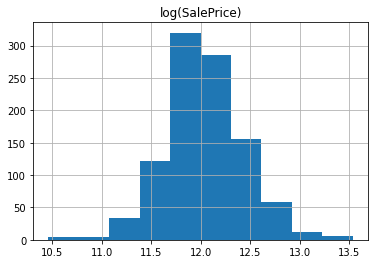

In [ ]:
# Check log transform - looks good
%matplotlib inline
imputed_embedded_train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
imputed_embedded_train['SalePrice'] = imputed_embedded_train['SalePrice'].log()
imputed_embedded_valid['SalePrice'] = imputed_embedded_valid['SalePrice'].log()
print(imputed_embedded_train[0:3, 'SalePrice'])

21. Train GLM on imputed, embedded inputs

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/grid/grid_search.py:427: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


     alpha                                                    model_ids  \
0     0.99  Grid_GLM_py_8_sid_aca5_model_python_1649949961614_9_model_4   
1     0.50  Grid_GLM_py_8_sid_aca5_model_python_1649949961614_9_model_3   
2     0.25  Grid_GLM_py_8_sid_aca5_model_python_1649949961614_9_model_2   
3     0.01  Grid_GLM_py_8_sid_aca5_model_python_1649949961614_9_model_1   

   residual_deviance  
0          11.051575  
1          11.214821  
2          11.358301  
3          16.568308  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_8_sid_aca5_model_python_1649949961614_9_model_4


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.99, lambda = 0.02629 )","nlambda = 100, lambda.max = 0.3395, lambda.min = 0.02629, lambda.1...",86,14,56,py_8_sid_aca5




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.03164939358731362
RMSE: 0.17790276441728953
MAE: 0.1147758868513937
RMSLE: 0.013663838668586574
R^2: 0.7959023238826659
Mean Residual Deviance: 0.03164939358731362
Null degrees of freedom: 1000
Residual degrees of freedom: 986
Null deviance: 155.2249079146511
Residual deviance: 31.681042980900934
AIC: -583.7743833487808

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.024077505156272567
RMSE: 0.1551692790350995
MAE: 0.11456296925171534
RMSLE: 0.011993149321324018
R^2: 0.8571197027616315
Mean Residual Deviance: 0.024077505156272567
Null degrees of freedom: 458
Residual degrees of freedom: 444
Null deviance: 77.67997881888854
Residual deviance: 11.051574866729108
AIC: -375.8674936207512

Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2022-04-14 15:55:46,0.000 sec,1,.34E0,1,0.155070,0.169237,0.99,NaN,,,,,,,,
1,,2022-04-14 15:55:46,0.004 sec,2,.32E0,2,0.145056,0.157301,0.99,NaN,,,,,,,,
2,,2022-04-14 15:55:46,0.008 sec,3,.31E0,2,0.135928,0.146412,0.99,NaN,,,,,,,,
3,,2022-04-14 15:55:46,0.011 sec,4,.3E0,2,0.127608,0.136478,0.99,NaN,,,,,,,,
4,,2022-04-14 15:55:46,0.014 sec,5,.28E0,2,0.120023,0.127415,0.99,NaN,,,,,,,,
5,,2022-04-14 15:55:46,0.018 sec,6,.27E0,2,0.113109,0.119146,0.99,NaN,,,,,,,,
6,,2022-04-14 15:55:46,0.026 sec,7,.26E0,2,0.106808,0.111602,0.99,NaN,,,,,,,,
7,,2022-04-14 15:55:46,0.030 sec,8,.25E0,2,0.101064,0.104718,0.99,NaN,,,,,,,,
8,,2022-04-14 15:55:46,0.036 sec,9,.23E0,2,0.095828,0.098438,0.99,NaN,,,,,,,,
9,,2022-04-14 15:55:46,0.040 sec,10,.22E0,2,0.091056,0.092707,0.99,NaN,,,,,,,,



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,reconstr_OverallQual,0.178225,1.000000,0.441101
1,reconstr_GrLivArea,0.047249,0.265111,0.116941
2,reconstr_WoodDeckSF,0.038054,0.213516,0.094182
3,reconstr_GarageArea,0.036175,0.202973,0.089531
4,reconstr_Fireplaces,0.035071,0.196780,0.086800
5,reconstr_EnclosedPorch,0.019284,0.108198,0.047726
6,Arch46,0.016638,0.093353,0.041178
7,Arch29,0.015691,0.088038,0.038834
8,reconstr_1stFlrSF,0.008943,0.050180,0.022135
9,reconstr_OpenPorchSF,0.004045,0.022698,0.010012



See the whole table with table.as_data_frame()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


SalePrice,predict
11.8494,12.0053
12.2061,12.3467
11.6784,11.6468
11.7906,11.9176
11.9117,11.8292
11.9767,12.0403
11.8451,11.6615
11.1346,11.3426
11.914,11.8816
11.8845,12.0442


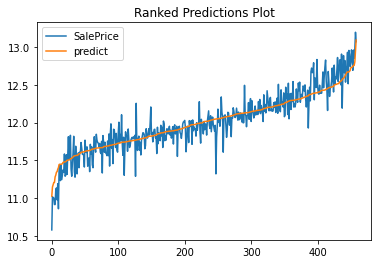

In [ ]:
alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
hyper_parameters = {"alpha":alpha_opts}

# initialize grid search
grid = H2OGridSearch(
    H2OGeneralizedLinearEstimator(
        family="gaussian",
        lambda_search=True,
        seed=SEED), # REQUIRES STUDENT INPUT
        hyper_params=hyper_parameters)
    
# train grid
grid.train(y='SalePrice',
           x=imputed_embedded_nums, 
           training_frame=imputed_embedded_train,
           validation_frame=imputed_embedded_valid,
           seed=SEED) # REQUIRES STUDENT INPUT

# show grid search results
print(grid.show())

best = grid.get_grid()[0]
print(best)
    
# plot top frame values
yhat_frame = imputed_embedded_valid.cbind(best.predict(imputed_embedded_valid))
print(yhat_frame[0:10, ['SalePrice', 'predict']])

# plot sorted predictions
yhat_frame_df = yhat_frame[['SalePrice', 'predict']].as_data_frame()
yhat_frame_df.sort_values(by='predict', inplace=True)
yhat_frame_df.reset_index(inplace=True, drop=True)
_ = yhat_frame_df.plot(title='Ranked Predictions Plot')

In [ ]:
# 22
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)